
## Adaptive Instance Normalization (AdaIN)

### Objective:
In this lab session, you'll learn and implement **Adaptive Instance Normalization (AdaIN)**, a powerful neural style transfer technique, using PyTorch. You will utilize a pre-trained VGG network as an encoder, and you'll construct a decoder to reconstruct images stylized according to a given style image.



### Key Concepts:
- **AdaIN** is a normalization technique that blends the content of one image with the style of another image by aligning their channel-wise mean and standard deviation of deep features.
- **Encoder-Decoder Architecture:** A pre-trained VGG network is used as the encoder for extracting content and style features, and a custom decoder is built for reconstructing stylized images.

### What You Will Do:
- Understand the structure and operation of AdaIN.
- Write and run PyTorch code to train a neural style transfer model using AdaIN.
- Experiment with different content and style images, observing how AdaIN affects the outcome.

 Import necessary libraries.

In [5]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
from torchvision import transforms

from PIL import ImageFile, Image
from torchvision.models import vgg19

from tqdm import tqdm

### Setup an Environment
Set up an environment for running style transfer tasks like AdaIN.


In [6]:
!gdown 1JFvZyosBWiYhznJI1g3zgLbe3uwjQQfe
!gdown 1T-iYOwWfiHrZhdHTj-_995fTWKZmM5qw
!gdown 1ooCdztluNU_p9appvc7irRC1nSdU_boL
!tar -xvf style.tar
!rm -f style.tar
!tar -xvf content.tar
!rm -f content.tar

Downloading...
From: https://drive.google.com/uc?id=1JFvZyosBWiYhznJI1g3zgLbe3uwjQQfe
To: /content/style.tar
100% 5.33M/5.33M [00:00<00:00, 25.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1T-iYOwWfiHrZhdHTj-_995fTWKZmM5qw
To: /content/content.tar
100% 1.63M/1.63M [00:00<00:00, 14.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ooCdztluNU_p9appvc7irRC1nSdU_boL
To: /content/vgg_normalised.pth
100% 80.1M/80.1M [00:01<00:00, 46.7MB/s]
style/
style/pseudo_class/
style/pseudo_class/antimonocromatismo.jpg
style/pseudo_class/asheville.jpg
style/pseudo_class/brushstrokes.jpg
style/pseudo_class/contrast_of_forms.jpg
style/pseudo_class/en_campo_gris.jpg
style/pseudo_class/flower_of_life.jpg
style/pseudo_class/goeritz.jpg
style/pseudo_class/impronte_d_artista.jpg
style/pseudo_class/la_muse.jpg
style/pseudo_class/mondrian.jpg
style/pseudo_class/mondrian_cropped.jpg
style/pseudo_class/picasso_seated_nude_hr.jpg
style/pseudo_class/picasso_self_portrait.jpg
style/pseudo_class

### Define AdaINDataset class
Define the **AdaINDataset class**, which is responsible for preparing and loading the datasets required for training an Adaptive Instance Normalization (AdaIN) neural style transfer model.
Initialization (__init__ method):

**Parameters:**
- content_path: Path to the directory containing content images.
- style_path: Path to the directory containing style images.
- batch_size: Number of images loaded per batch for training.

**Image Transformations (self.T):**
- Images are resized to 512x512.
- Random cropping is applied to select patches of size 256x256 with padding 20, introducing variability and augmenting the dataset.
- Images are converted to PyTorch tensors (transforms.ToTensor()), normalizing pixel values to the [0,1] range.

**Dataset Preparation:**
- self.content_folder and self.style_folder: Utilize ImageFolder from torchvision.datasets to load images from directories, applying transformations (self.T).
- self.content_loader and self.style_loader: Utilize PyTorch DataLoader to load datasets in batches, with shuffle=True to randomize the image order in each epoch, improving training robustness.

In [7]:
class AdaINDataset:

    def __init__(self, content_path, style_path, batch_size) -> None:

        self.T = transforms.Compose([
            transforms.Resize(512),
            transforms.RandomCrop((256, 256), padding=(20, 20)),
            transforms.ToTensor(),
        ])

        self.content_folder = ImageFolder(content_path, transform=self.T)
        self.style_folder = ImageFolder(style_path, transform=self.T)

        self.content_loader = DataLoader(self.content_folder, batch_size, shuffle=True)
        self.style_loader = DataLoader(self.style_folder, batch_size, shuffle=True)

### Define the loss function (style loss & content loss)
The AdaINLoss class calculates the total loss for training an AdaIN style-transfer model. It consists of:
- **Initialization:** Takes a pretrained encoder (enc) for feature extraction and a style_weight to balance style and content losses.
- **Content Loss:** Computes Mean Squared Error (MSE) between AdaIN-aligned content and predicted features.
- **Style Loss:** Computes MSE between the channel-wise mean and standard deviation of style and predicted features.
- **Total Loss (calculate_loss):** Combines content and style losses, scaled by style_weight, to guide the training process.

In [8]:
class AdaINLoss:

    def __init__(self, enc, style_weight) -> None:
        self.mse = nn.MSELoss()
        self.loss_network = enc
        self.style_weight = style_weight

    # a simple mse for the content loss
    def content_loss(self, realigned_content, pred_feature_last):
        return self.mse(realigned_content, pred_feature_last)

    # mse of the channel-wise mean and std for style loss
    def style_loss(self, style_features, pred_features):
        style_loss = 0
        for s_ft, p_ft in zip(style_features, pred_features):
            B, C = s_ft.shape[0], s_ft.shape[1]
            s_ft, p_ft = s_ft.view(B, C, -1), p_ft.view(B, C, -1)
            mean_loss = self.mse(s_ft.mean(dim=2), p_ft.mean(dim=2))
            std_loss = self.mse(s_ft.std(dim=2), p_ft.std(dim=2))
            style_loss += (mean_loss + std_loss)
        return style_loss


    def calculate_loss(self, style_features, pred_img, realigned_content):
        pred_features = self.loss_network(pred_img)
        content_loss = self.content_loss(realigned_content, pred_features[-1])
        style_loss = self.style_loss(style_features, pred_features)
        return content_loss + (style_loss * self.style_weight)

### Define the Encoder and Decoder Modules
**Encoder:**
Implements a pretrained VGG-like convolutional neural network used for feature extraction. It selectively outputs intermediate layer activations used for AdaIN. The encoder layers are fixed (no training), ensuring stable feature extraction.

**Decoder:**
Mirrors the Encoder, reconstructing images from encoded features. It reverses the encoder operations:
- Convolutional layers' input/output channels are swapped.
- Reflection padding and ReLU layers are reversed in order.
- Max pooling layers are replaced by nearest-neighbor upsampling.

Together, these modules encode and decode images, facilitating style transfer with AdaIN.

In [9]:
# vgg encoder model
class VGGEncoder(nn.Module):

    def __init__(self, weight_path=None) -> None:
        super(VGGEncoder, self).__init__()
        # layers to extract features from
        self.feature_layers = [3, 10, 17, 30]

        # creating model and adding first layer
        self.model = nn.ModuleList()
        self.model.append(nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1, 1)))
        self.model.append(nn.ReflectionPad2d((1, 1, 1, 1)))

        # parameters for remaining layers
        # (in_channels, out_channels, kernel_size)
        params = [
            (3, 64, (3, 3)),
            (64, 64, (3, 3)),
            (64, 128, (3, 3)),
            (128, 128, (3, 3)),
            (128, 256, (3, 3)),
            (256, 256, (3, 3)),
            (256, 256, (3, 3)),
            (256, 256, (3, 3)),
            (256, 512, (3, 3)),
            (512, 512, (3, 3)),
            (512, 512, (3, 3)),
            (512, 512, (3, 3)),
            (512, 512, (3, 3)),
            (512, 512, (3, 3)),
            (512, 512, (3, 3)),
            (512, 512, (3, 3))
        ]

        # adding layers to model
        # also adding a maxpool layer whenever number of out_channels changes
        for i, param in enumerate(params[:-1]):
            self.model.append(nn.Conv2d(in_channels=param[0], out_channels=param[1], kernel_size=param[2]))
            self.model.append(nn.ReLU())
            if params[i + 1][0] != params[i + 1][1]:
                self.model.append(nn.MaxPool2d(kernel_size=(2,2), stride=(2,2), padding=(0,0), ceil_mode=True))
            self.model.append(nn.ReflectionPad2d((1, 1, 1, 1)))

        # inserting extra maxpool layer based on vgg architecture
        self.model.insert(40, nn.MaxPool2d(kernel_size=(2,2), stride=(2,2), padding=(0,0), ceil_mode=True))

        # adding last layer
        self.model.append(nn.Conv2d(in_channels=params[-1][0], out_channels=params[-1][1], kernel_size=params[-1][2]))
        self.model.append(nn.ReLU())

        # loading pretrained model weights if path is provided
        if weight_path:
            self.model.load_state_dict(torch.load(weight_path, map_location="cpu"))

        # encoder is fully pretrained, so no weights need to be adjusted
        # gradients need not be accumulated
        for param in self.model.parameters():
            param.requires_grad = False

    def forward(self, x):
        # list to store activations from layers in self.feature_layers
        activations = []
        for i, layer in enumerate(self.model[:31]):
            x = layer(x)
            if i in self.feature_layers:
                activations.append(x)
        return activations


class VGGDecoder(nn.Module):

    def __init__(self, encoder, weight_path=None) -> None:
        super(VGGDecoder, self).__init__()
        # decoder model
        self.decoder = nn.ModuleList()

        # iterate through encoder layer in reverse order, not including the last 2
        # interchange reflectionpad and relu layers
        # replace maxpool with upsample
        # interchange in_channels and out_channels in cover layers
        for layer in encoder.model[:31][::-1][:-2]:
            if isinstance(layer, nn.ReflectionPad2d):
                self.decoder.append(nn.ReLU())
            elif isinstance(layer, nn.ReLU):
                self.decoder.append(nn.ReflectionPad2d((1, 1, 1, 1)))
            elif isinstance(layer, nn.MaxPool2d):
                self.decoder.append(nn.Upsample(scale_factor=2, mode='nearest'))
            elif isinstance(layer, nn.Conv2d):
                layer = nn.Conv2d(
                    in_channels=layer.out_channels,
                    out_channels=layer.in_channels,
                    kernel_size=layer.kernel_size
                )
                self.decoder.append(layer)

        # load weights if weight path provided
        if weight_path:
            self.decoder.load_state_dict(torch.load(weight_path, map_location="cpu"))

    def forward(self, x):
        for layer in self.decoder:
            x = layer(x)
        return x

## Task 1: Implement AdaIN operation
The AdaIN_realign function aligns content image features to style image statistics using Adaptive Instance Normalization (AdaIN). It:
- Computes channel-wise mean and standard deviation of both content and style features.
- Normalizes content features (removes content statistics).
- Re-scales normalized content features using style features' mean and standard deviation.

This realignment blends the style characteristics into the content image features.

For task 1, details of AdaIN are provided in slide 74 of Week9,10 lecture slides. 

In summary, given content feature \( c \) and style feature \( s \), the AdaIN transformation is defined as:

$$
\text{AdaIN}(c, s) = \sigma(s) \cdot \left( \frac{c - \mu(c)}{\sigma(c) + \epsilon} \right) + \mu(s)
$$

**Where:**


- $\mu(c),\ \sigma(c)$: Mean and standard deviation of the content feature
- $\mu(s),\ \sigma(s)$: Mean and standard deviation of the style feature
- $ \epsilon$: A small constant (e.g., $10^{-5}$) to avoid division by zero


In [ ]:
def AdaIN_realign(style, content):
    # flatten images while retaining batchs and channels, compute mean and std
    B, C = content.shape[0], content.shape[1]
    content_mean = content.view(B, C, -1).mean(dim=2)
    content_std = content.view(B, C, -1).std(dim=2)

    # reshape mean and std to perform normalization and realignment
    content_mean, content_std = content_mean.view(B, C, 1, 1), content_std.view(B, C, 1, 1)
    content_mean, content_std = content_mean.expand(content.size()), content_std.expand(content.size())


    ############## ENTER YOUR CODE HERE ##############
    # compute mean and std and reshape for style
    style_mean = 
    style_std = 
    style_mean, style_std = 
    style_mean, style_std = 

    # normalize content features. Small constant added to avoid zero division.
    normalized = 
    # realign normalized content features with style mean and std
    realigned = 
    ####################################################

    return realigned

### Define the Hyperparameters and Load the Pretrained VGG Model
Initializes the AdaIN training setup by defining hyperparameters, loading the pretrained VGG encoder, building the decoder, setting up the loss function, and preparing content and style datasets for training.

In [11]:
epochs = 10
style_weight = 1000000
lr = 0.0001
batch_size = 1
encoder = VGGEncoder("vgg_normalised.pth").cuda()
decoder = VGGDecoder(encoder).cuda()
adain_loss = AdaINLoss(encoder, style_weight)
dataset = AdaINDataset('content', 'style', batch_size)

<ipython-input-9-6371d6029f10>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(weight_path, map_location="cpu"))


### AdaIN Training
Train the decoder network for style transfer using the AdaIN (Adaptive Instance Normalization) method, while keeping the encoder fixed.

This training loop performs the core learning of the AdaIN model by updating only the decoder, using style and content images in pairs. It leverages deep feature statistics (mean and std) from the VGG encoder to achieve style transfer and guides learning using a custom loss function tailored to preserve content while transferring style.

In [12]:
optimizer = optim.Adam(decoder.parameters(), lr=lr)

for e in range(1, epochs + 1):
    loop = tqdm(
        enumerate(zip(dataset.content_loader, dataset.style_loader)),
        total=len(dataset.content_loader),
        leave=True,
        position=0
    )
    loop.set_description(f"Epoch - {e} | ")
    for i, ((content, _), (style, _)) in loop:
        content, style = content.cuda(), style.cuda()
        optimizer.zero_grad()
        decoder.train()

        content_features = encoder(content)
        style_features = encoder(style)
        realigned_content = AdaIN_realign(style_features[-1], content_features[-1])
        pred_img = decoder(realigned_content).clip(0,1)

        loss = adain_loss.calculate_loss(style_features, pred_img, realigned_content)
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())

        if i % 10 == 0:
            torch.save(decoder.state_dict(), 'dec.pth')

Epoch - 1 | : 100%|██████████| 11/11 [00:02<00:00,  4.12it/s, loss=7.55e+6]
Epoch - 2 | : 100%|██████████| 11/11 [00:00<00:00, 12.20it/s, loss=1.28e+7]
Epoch - 3 | : 100%|██████████| 11/11 [00:00<00:00, 12.11it/s, loss=2.58e+7]
Epoch - 4 | : 100%|██████████| 11/11 [00:00<00:00, 11.80it/s, loss=3.34e+7]
Epoch - 5 | : 100%|██████████| 11/11 [00:00<00:00, 12.14it/s, loss=9.22e+6]
Epoch - 6 | : 100%|██████████| 11/11 [00:01<00:00, 10.37it/s, loss=7.73e+6]
Epoch - 7 | : 100%|██████████| 11/11 [00:01<00:00, 10.06it/s, loss=1.71e+7]
Epoch - 8 | : 100%|██████████| 11/11 [00:01<00:00, 10.99it/s, loss=1.87e+7]
Epoch - 9 | : 100%|██████████| 11/11 [00:00<00:00, 12.35it/s, loss=9.75e+6]
Epoch - 10 | : 100%|██████████| 11/11 [00:01<00:00, 10.51it/s, loss=6.28e+6]


### Download well-trained Decoder and Test Images
Prepare test input images by downloading and extracting them into the working directory, enabling later evaluation or inference with the trained style transfer model.

In [13]:
!gdown 1ch17KgnIzKOU_-9fNrcc3WI8iVXsRBLt
!gdown 1bAPBLf12hRTuHtOSkaQ9TvC0d92sRxWA
!tar -xvf test-images.tar
!rm -f test-images.tar

Downloading...
From: https://drive.google.com/uc?id=1ch17KgnIzKOU_-9fNrcc3WI8iVXsRBLt
To: /content/decoder.pth
100% 14.0M/14.0M [00:00<00:00, 41.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bAPBLf12hRTuHtOSkaQ9TvC0d92sRxWA
To: /content/test-images.tar
100% 982k/982k [00:00<00:00, 9.91MB/s]
test-images/
test-images/content.jpg
test-images/style1.jpg
test-images/style2.jpg
test-images/style3.jpg
test-images/style4.jpg
test-images/style5.jpg
test-images/style6.jpg
test-images/style7.jpg
test-images/style8.jpg


### Test Style Transfer
Perform style transfer inference using a pretrained AdaIN model. It takes one content image and eight different style images, applies Adaptive Instance Normalization to combine each style with the content, and reconstructs the stylized outputs using the trained decoder. 

The results are then visualized in a 4×2 grid of images for easy comparison. This allows you to qualitatively assess how different styles affect the same content image.

<ipython-input-9-6371d6029f10>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(weight_path, map_location="cpu"))
<ipython-input-9-637

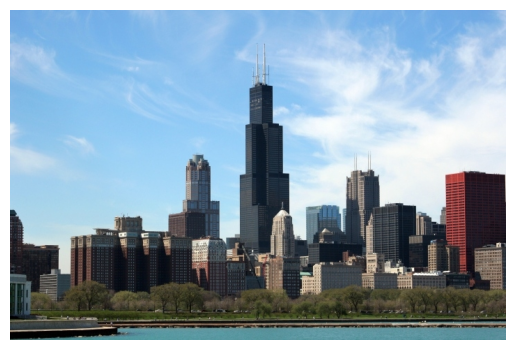

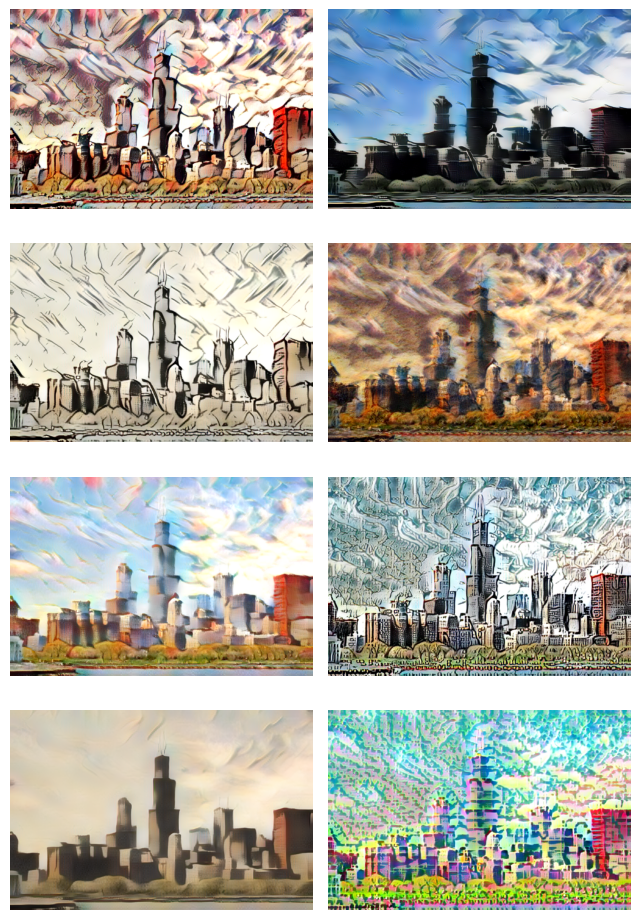

In [61]:
T = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor()
])

to_pil = transforms.ToPILImage()

enc = VGGEncoder(weight_path="vgg_normalised.pth").cuda()
dec = VGGDecoder(enc, weight_path="decoder.pth").cuda()

content_img = Image.open("test-images/content.jpg")
styles = [Image.open(f"test-images/style{i}.jpg").resize(content_img.size) for i in range(1,9)]

plt.imshow(content_img)
plt.axis(False)
plt.show()

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(8,12))
plt.subplots_adjust(wspace=0.05, hspace=0.05)
ax = ax.flatten()

for axis, style in zip(ax, styles):
    content, style = T(content_img).cuda(), T(style).cuda()
    content, style = content.unsqueeze(0), style.unsqueeze(0)

    content_enc, style_enc = enc(content)[-1], enc(style)[-1]
    content_realigned = AdaIN_realign(style_enc, content_enc)
    pred_img = dec(content_realigned)

    predicted_img = to_pil(pred_img[0].clip(0,1))
    axis.imshow(predicted_img)
    axis.axis(False)

## Task 2: Content-style Trade-off (You can change the style!)
This demonstrates how AdaIN allows interpolation between content and style using a blending factor alpha.
- The content and selected style image are fixed.
- Several stylized outputs are generated with varying alpha values (from 0.25 to 1.0), controlling the degree of stylization:
  - alpha = 0: pure content image.
  - alpha = 1: fully stylized.
  - Intermediate alphas create a smooth blend.

The output is visualized in a single row showing the progression from content to stylized image. This helps understand style strength control in AdaIN.

**For Task 2, please refer to slide # 77 of Lecture Week 9,10.**

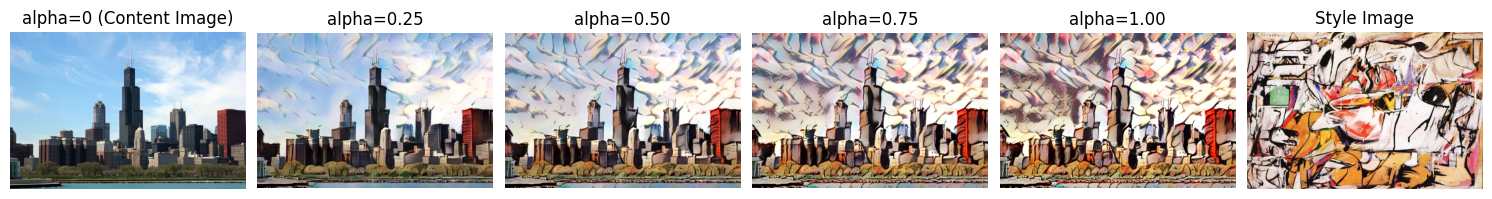

In [ ]:
style_img = styles[0] # change the style here
alphas = [0.25, 0.5, 0.75, 1.]

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(19,3))
plt.subplots_adjust(wspace=0.05)
ax = ax.flatten()

ax[0].imshow(content_img)
ax[0].axis(False)
ax[0].set_title('alpha=0 (Content Image)')
ax[-1].imshow(style_img)
ax[-1].axis(False)
ax[-1].set_title('Style Image')

content, style = T(content_img).cuda(), T(style_img).cuda()
content, style = content.unsqueeze(0), style.unsqueeze(0)

for axis, alpha in zip(ax[1:-1], alphas):
    content_enc, style_enc = enc(content)[-1], enc(style)[-1]
    content_realigned = AdaIN_realign(style_enc, content_enc)
    
    ############## ENTER YOUR CODE HERE ##############
    pred_img = 

    ##################################################

    predicted_img = to_pil(pred_img[0].clip(0,1))
    axis.imshow(predicted_img)
    axis.set_title('alpha={:.2f}'.format(alpha))
    axis.axis(False)

plt.show()

### Interpolation (Optional, Provided for better understanding)
This visualizes style interpolation between two different styles using AdaIN.
- It fixes one content image and selects two distinct style images.
- Using a list of weights, it generates blended styles by linearly interpolating between the AdaIN-transformed features of both styles.
- The resulting images represent a gradual shift from Style 1 to Style 2 applied to the same content image.

The output shows how AdaIN can blend multiple artistic styles smoothly, offering creative flexibility in style transfer applications.

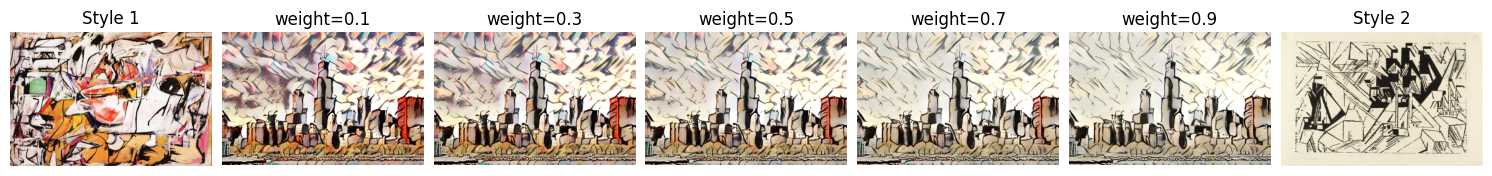

In [65]:
style_img1 = styles[0] # change the style here
style_img2 = styles[2] # change the style here
weights = [0.1, 0.3, 0.5, 0.7, 0.9]

fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(19,3))
plt.subplots_adjust(wspace=0.05)
ax = ax.flatten()

ax[0].imshow(style_img1)
ax[0].axis(False)
ax[0].set_title('Style 1')
ax[-1].imshow(style_img2)
ax[-1].axis(False)
ax[-1].set_title('Style 2')

content, style1, style2 = T(content_img).cuda(), T(style_img1).cuda(), T(style_img2).cuda()
content, style1, style2 = content.unsqueeze(0), style1.unsqueeze(0), style2.unsqueeze(0)

for axis, weight in zip(ax[1:-1], weights):
    content_enc, style1_enc, style2_enc = enc(content)[-1], enc(style1)[-1], enc(style2)[-1]
    content_realigned1 = AdaIN_realign(style1_enc, content_enc)
    content_realigned2 = AdaIN_realign(style2_enc, content_enc)
    pred_img = dec((1-weight) * content_realigned1 + weight * content_realigned2)

    predicted_img = to_pil(pred_img[0].clip(0,1))
    axis.imshow(predicted_img)
    axis.set_title('weight={:.1f}'.format(weight))
    axis.axis(False)

plt.show()

### **References**

- This content is based on https://github.com/gursi26/adain-style-transfer/tree/main
- VGG encoder and pretrained model are from https://github.com/gursi26/adain-style-transfer/tree/main
- The style and content images are from https://github.com/naoto0804/pytorch-AdaIN